<h1><center><font size="6">APTOS Diabetic Retinopathy</font></center></h1>




<img src="https://www.eye7.in/wp-content/uploads/illustration-showing-diabetic-retinopathy.jpg" width="800"></img>



<br>



# <a id='0'>Content</a>

- <a href='#1'>Loading & Exploration</a>  : A quick overview of the dataset
- <a href='#2'>EfficientNet Utility Code</a> : EfficientNet codes taken from GitHub
- <a href='#3'>Cropping Images and using GaussianBlur</a> : We see that all images have black background and lot of black pixels at the edges. These are redundant pixels. So, we crop the images setting a threshold for intensity to which pixels to consider.
- <a href='#4'>Mixup and Data Generator</a> :  We show how to create a data generator that will perform random transformation to our datasets (flip vertically/horizontally, rotation, zooming). This will help our model generalize better to the data, since it is fairly small (only ~3000 images). 
- <a href='#5'> Quadratic Weight Kappa</a>    : A thorough overview of the metric used for this competition, with an intuitive example. Check it out!
- <a href='#6'>EfficientNet B5</a>   : We will use a EfficientNetB5 pre-trained . We will finetune it using Adam for 20 epochs, and evaluate it on an unseen validation set.   
- <a href='#7'>Training & Evaluation</a>



In [1]:
# To have reproducible results
seed = 5 
import numpy as np 
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# <a id='1'>Loading and Exploration</a> 

In [2]:
import json
import math
import os

import cv2
from PIL import Image
# from keras_efficientnets import *
from keras import layers
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
print(os.listdir('../input'))
%matplotlib inline

IMG_SIZE=256
BATCH_SIZE = 16

Using TensorFlow backend.


['efficientnet-keras-weights-b0b5', 'diabetic-retinopathy-resized', 'aptos2019-blindness-detection', 'effb3-train-on-old-new-as-val']


# <a id='2'>EfficientNet Utility Codes</a> 

In [3]:
''' ## Credits
All credits are due to https://github.com/qubvel/efficientnet
Thanks so much for your contribution!

## Usage:
Adding this utility script to your kernel, and you will be able to 
use all models just like standard Keras pretrained model. For details see
https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/100186

## Pretrained Weights
https://www.kaggle.com/ratthachat/efficientnet-keras-weights-b0b5/
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
import keras.layers as KL
from keras.initializers import Initializer
from keras.utils.generic_utils import get_custom_objects

import os
import re
import collections
import math
import six
from six.moves import xrange  # pylint: disable=redefined-builtin

import keras.models as KM
from keras.utils import get_file

MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]

MAP_INTERPOLATION_TO_ORDER = {
    "nearest": 0,
    "bilinear": 1,
    "biquadratic": 2,
    "bicubic": 3,
}


def center_crop_and_resize(image, image_size, crop_padding=32, interpolation="bicubic"):
    assert image.ndim in {2, 3}
    assert interpolation in MAP_INTERPOLATION_TO_ORDER.keys()

    h, w = image.shape[:2]

    padded_center_crop_size = int(
        (image_size / (image_size + crop_padding)) * min(h, w)
    )
    offset_height = ((h - padded_center_crop_size) + 1) // 2
    offset_width = ((w - padded_center_crop_size) + 1) // 2

    image_crop = image[
        offset_height : padded_center_crop_size + offset_height,
        offset_width : padded_center_crop_size + offset_width,
    ]
    resized_image = resize(
        image_crop,
        (image_size, image_size),
        order=MAP_INTERPOLATION_TO_ORDER[interpolation],
        preserve_range=True,
    )

    return resized_image


def preprocess_input(x):
    assert x.ndim in (3, 4)
    assert x.shape[-1] == 3

    x = x - np.array(MEAN_RGB)
    x = x / np.array(STDDEV_RGB)

    return x

class EfficientConv2DKernelInitializer(Initializer):
    """Initialization for convolutional kernels.
    The main difference with tf.variance_scaling_initializer is that
    tf.variance_scaling_initializer uses a truncated normal with an uncorrected
    standard deviation, whereas here we use a normal distribution. Similarly,
    tf.contrib.layers.variance_scaling_initializer uses a truncated normal with
    a corrected standard deviation.
    Args:
      shape: shape of variable
      dtype: dtype of variable
      partition_info: unused
    Returns:
      an initialization for the variable
    """

    def __call__(self, shape, dtype=K.floatx(), **kwargs):
        kernel_height, kernel_width, _, out_filters = shape
        fan_out = int(kernel_height * kernel_width * out_filters)
        return tf.random_normal(
            shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype
        )


class EfficientDenseKernelInitializer(Initializer):
    """Initialization for dense kernels.
    This initialization is equal to
      tf.variance_scaling_initializer(scale=1.0/3.0, mode='fan_out',
                                      distribution='uniform').
    It is written out explicitly here for clarity.
    Args:
      shape: shape of variable
      dtype: dtype of variable
    Returns:
      an initialization for the variable
    """

    def __call__(self, shape, dtype=K.floatx(), **kwargs):
        """Initialization for dense kernels.
        This initialization is equal to
          tf.variance_scaling_initializer(scale=1.0/3.0, mode='fan_out',
                                          distribution='uniform').
        It is written out explicitly here for clarity.
        Args:
          shape: shape of variable
          dtype: dtype of variable
        Returns:
          an initialization for the variable
        """
        init_range = 1.0 / np.sqrt(shape[1])
        return tf.random_uniform(shape, -init_range, init_range, dtype=dtype)


conv_kernel_initializer = EfficientConv2DKernelInitializer()
dense_kernel_initializer = EfficientDenseKernelInitializer()


get_custom_objects().update(
    {
        "EfficientDenseKernelInitializer": EfficientDenseKernelInitializer,
        "EfficientConv2DKernelInitializer": EfficientConv2DKernelInitializer,
    }
)

class Swish(KL.Layer):
    def call(self, inputs):
        return tf.nn.swish(inputs)


class DropConnect(KL.Layer):
    def __init__(self, drop_connect_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, training=None):
        def drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            # Compute drop_connect tensor
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += tf.random_uniform(
                [batch_size, 1, 1, 1], dtype=inputs.dtype
            )
            binary_tensor = tf.floor(random_tensor)
            output = tf.div(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(drop_connect, inputs, training=training)

    def get_config(self):
        config = super().get_config()
        config["drop_connect_rate"] = self.drop_connect_rate
        return config


get_custom_objects().update({"DropConnect": DropConnect, "Swish": Swish})


IMAGENET_WEIGHTS = {
    "efficientnet-b0": {
        "name": "efficientnet-b0_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000.h5",
        "md5": "bca04d16b1b8a7c607b1152fe9261af7",
    },
    "efficientnet-b0-notop": {
        "name": "efficientnet-b0_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000_notop.h5",
        "md5": "45d2f3b6330c2401ef66da3961cad769",
    },
    "efficientnet-b1": {
        "name": "efficientnet-b1_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000.h5",
        "md5": "bd4a2b82f6f6bada74fc754553c464fc",
    },
    "efficientnet-b1-notop": {
        "name": "efficientnet-b1_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000_notop.h5",
        "md5": "884aed586c2d8ca8dd15a605ec42f564",
    },
    "efficientnet-b2": {
        "name": "efficientnet-b2_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000.h5",
        "md5": "45b28b26f15958bac270ab527a376999",
    },
    "efficientnet-b2-notop": {
        "name": "efficientnet-b2_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000_notop.h5",
        "md5": "42fb9f2d9243d461d62b4555d3a53b7b",
    },
    "efficientnet-b3": {
        "name": "efficientnet-b3_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000.h5",
        "md5": "decd2c8a23971734f9d3f6b4053bf424",
    },
    "efficientnet-b3-notop": {
        "name": "efficientnet-b3_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000_notop.h5",
        "md5": "1f7d9a8c2469d2e3d3b97680d45df1e1",
    },
    "efficientnet-b4": {
        "name": "efficientnet-b4_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000.h5",
        "md5": "01df77157a86609530aeb4f1f9527949",
    },
    "efficientnet-b4-notop": {
        "name": "efficientnet-b4_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000_notop.h5",
        "md5": "e7c3b780f050f8f49c800f23703f285c",
    },
    "efficientnet-b5": {
        "name": "efficientnet-b5_imagenet_1000.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000.h5",
        "md5": "c31311a1a38b5111e14457145fccdf32",
    },
    "efficientnet-b5-notop": {
        "name": "efficientnet-b5_imagenet_1000_notop.h5",
        "url": "https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000_notop.h5",
        "md5": "a09b36129b41196e0bb659fd84fbdd5f",
    },
}


GlobalParams = collections.namedtuple(
    "GlobalParams",
    [
        "batch_norm_momentum",
        "batch_norm_epsilon",
        "dropout_rate",
        "data_format",
        "num_classes",
        "width_coefficient",
        "depth_coefficient",
        "depth_divisor",
        "min_depth",
        "drop_connect_rate",
    ],
)
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)

BlockArgs = collections.namedtuple(
    "BlockArgs",
    [
        "kernel_size",
        "num_repeat",
        "input_filters",
        "output_filters",
        "expand_ratio",
        "id_skip",
        "strides",
        "se_ratio",
    ],
)
# defaults will be a public argument for namedtuple in Python 3.7
# https://docs.python.org/3/library/collections.html#collections.namedtuple
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


def efficientnet_params(model_name):
    """Get efficientnet params based on model name."""
    params_dict = {
        # (width_coefficient, depth_coefficient, resolution, dropout_rate)
        "efficientnet-b0": (1.0, 1.0, 224, 0.2),
        "efficientnet-b1": (1.0, 1.1, 240, 0.2),
        "efficientnet-b2": (1.1, 1.2, 260, 0.3),
        "efficientnet-b3": (1.2, 1.4, 300, 0.3),
        "efficientnet-b4": (1.4, 1.8, 380, 0.4),
        "efficientnet-b5": (1.6, 2.2, 456, 0.4),
        "efficientnet-b6": (1.8, 2.6, 528, 0.5),
        "efficientnet-b7": (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """Block Decoder for readability."""

    def _decode_block_string(self, block_string):
        """Gets a block through a string notation of arguments."""
        assert isinstance(block_string, str)
        ops = block_string.split("_")
        options = {}
        for op in ops:
            splits = re.split(r"(\d.*)", op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        if "s" not in options or len(options["s"]) != 2:
            raise ValueError("Strides options should be a pair of integers.")

        return BlockArgs(
            kernel_size=int(options["k"]),
            num_repeat=int(options["r"]),
            input_filters=int(options["i"]),
            output_filters=int(options["o"]),
            expand_ratio=int(options["e"]),
            id_skip=("noskip" not in block_string),
            se_ratio=float(options["se"]) if "se" in options else None,
            strides=[int(options["s"][0]), int(options["s"][1])],
        )

    def _encode_block_string(self, block):
        """Encodes a block to a string."""
        args = [
            "r%d" % block.num_repeat,
            "k%d" % block.kernel_size,
            "s%d%d" % (block.strides[0], block.strides[1]),
            "e%s" % block.expand_ratio,
            "i%d" % block.input_filters,
            "o%d" % block.output_filters,
        ]
        if block.se_ratio > 0 and block.se_ratio <= 1:
            args.append("se%s" % block.se_ratio)
        if block.id_skip is False:
            args.append("noskip")
        return "_".join(args)

    def decode(self, string_list):
        """Decodes a list of string notations to specify blocks inside the network.
    Args:
      string_list: a list of strings, each string is a notation of block.
    Returns:
      A list of namedtuples to represent blocks arguments.
    """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(self._decode_block_string(block_string))
        return blocks_args

    def encode(self, blocks_args):
        """Encodes a list of Blocks to a list of strings.
    Args:
      blocks_args: A list of namedtuples to represent blocks arguments.
    Returns:
      a list of strings, each string is a notation of block.
    """
        block_strings = []
        for block in blocks_args:
            block_strings.append(self._encode_block_string(block))
        return block_strings


def efficientnet(
    width_coefficient=None,
    depth_coefficient=None,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
):
    """Creates a efficientnet model."""
    blocks_args = [
        "r1_k3_s11_e1_i32_o16_se0.25",
        "r2_k3_s22_e6_i16_o24_se0.25",
        "r2_k5_s22_e6_i24_o40_se0.25",
        "r3_k3_s22_e6_i40_o80_se0.25",
        "r3_k5_s11_e6_i80_o112_se0.25",
        "r4_k5_s22_e6_i112_o192_se0.25",
        "r1_k3_s11_e6_i192_o320_se0.25",
    ]
    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        data_format="channels_last",
        num_classes=1000,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
    )
    decoder = BlockDecoder()
    return decoder.decode(blocks_args), global_params


def get_model_params(model_name, override_params=None):
    """Get the block args and global params for a given model."""
    if model_name.startswith("efficientnet"):
        width_coefficient, depth_coefficient, input_shape, dropout_rate = efficientnet_params(
            model_name
        )
        blocks_args, global_params = efficientnet(
            width_coefficient, depth_coefficient, dropout_rate
        )
    else:
        raise NotImplementedError("model name is not pre-defined: %s" % model_name)

    if override_params:
        # ValueError will be raised here if override_params has fields not included
        # in global_params.
        global_params = global_params._replace(**override_params)

    # print('global_params= %s', global_params)
    # print('blocks_args= %s', blocks_args)
    return blocks_args, global_params, input_shape



__all__ = [
    "EfficientNet",
    "EfficientNetB0",
    "EfficientNetB1",
    "EfficientNetB2",
    "EfficientNetB3",
    "EfficientNetB4",
    "EfficientNetB5",
    "EfficientNetB6",
    "EfficientNetB7",
]


def round_filters(filters, global_params):
    """Round number of filters based on depth multiplier."""
    orig_f = filters
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    # print('round_filter input={} output={}'.format(orig_f, new_filters))
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Round number of filters based on depth multiplier."""
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def SEBlock(block_args, global_params):
    num_reduced_filters = max(1, int(block_args.input_filters * block_args.se_ratio))
    filters = block_args.input_filters * block_args.expand_ratio
    if global_params.data_format == "channels_first":
        channel_axis = 1
        spatial_dims = [2, 3]
    else:
        channel_axis = -1
        spatial_dims = [1, 2]

    def block(inputs):
        x = inputs
        x = KL.Lambda(lambda a: K.mean(a, axis=spatial_dims, keepdims=True))(x)
        x = KL.Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=True,
        )(x)
        x = Swish()(x)
        # Excite
        x = KL.Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=True,
        )(x)
        x = KL.Activation("sigmoid")(x)
        out = KL.Multiply()([x, inputs])
        return out

    return block


def MBConvBlock(block_args, global_params, drop_connect_rate=None):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon

    if global_params.data_format == "channels_first":
        channel_axis = 1
        spatial_dims = [2, 3]
    else:
        channel_axis = -1
        spatial_dims = [1, 2]

    has_se = (
        (block_args.se_ratio is not None)
        and (block_args.se_ratio > 0)
        and (block_args.se_ratio <= 1)
    )

    filters = block_args.input_filters * block_args.expand_ratio
    kernel_size = block_args.kernel_size

    def block(inputs):

        if block_args.expand_ratio != 1:
            x = KL.Conv2D(
                filters,
                kernel_size=[1, 1],
                strides=[1, 1],
                kernel_initializer=conv_kernel_initializer,
                padding="same",
                use_bias=False,
            )(inputs)
            x = KL.BatchNormalization(
                axis=channel_axis,
                momentum=batch_norm_momentum,
                epsilon=batch_norm_epsilon,
            )(x)
            x = Swish()(x)
        else:
            x = inputs

        x = KL.DepthwiseConv2D(
            [kernel_size, kernel_size],
            strides=block_args.strides,
            depthwise_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=False,
        )(x)
        x = KL.BatchNormalization(
            axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
        )(x)
        x = Swish()(x)

        if has_se:
            x = SEBlock(block_args, global_params)(x)

        # output phase

        x = KL.Conv2D(
            block_args.output_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding="same",
            use_bias=False,
        )(x)
        x = KL.BatchNormalization(
            axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
        )(x)

        if block_args.id_skip:
            if (
                all(s == 1 for s in block_args.strides)
                and block_args.input_filters == block_args.output_filters
            ):
                # only apply drop_connect if skip presents.
                if drop_connect_rate:
                    x = DropConnect(drop_connect_rate)(x)
                x = KL.Add()([x, inputs])
        return x

    return block


def EfficientNet(
    input_shape, block_args_list, global_params, input_tensor=None, include_top=True, pooling=None
):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon
    if global_params.data_format == "channels_first":
        channel_axis = 1
    else:
        channel_axis = -1

    # Stem part
    if input_tensor is None:
        inputs = KL.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            inputs = KL.Input(tensor=input_tensor, shape=input_shape)
        else:
            inputs = input_tensor
    x = inputs
    x = KL.Conv2D(
        filters=round_filters(32, global_params),
        kernel_size=[3, 3],
        strides=[2, 2],
        kernel_initializer=conv_kernel_initializer,
        padding="same",
        use_bias=False,
    )(x)
    x = KL.BatchNormalization(
        axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
    )(x)
    x = Swish()(x)

    # Blocks part
    block_idx = 1
    n_blocks = sum([block_args.num_repeat for block_args in block_args_list])
    drop_rate = global_params.drop_connect_rate or 0
    drop_rate_dx = drop_rate / n_blocks

    for block_args in block_args_list:
        assert block_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters, global_params),
            output_filters=round_filters(block_args.output_filters, global_params),
            num_repeat=round_repeats(block_args.num_repeat, global_params),
        )

        # The first block needs to take care of stride and filter size increase.
        x = MBConvBlock(
            block_args, global_params, drop_connect_rate=drop_rate_dx * block_idx
        )(x)
        block_idx += 1

        if block_args.num_repeat > 1:
            block_args = block_args._replace(
                input_filters=block_args.output_filters, strides=[1, 1]
            )

        for _ in xrange(block_args.num_repeat - 1):
            x = MBConvBlock(
                block_args, global_params, drop_connect_rate=drop_rate_dx * block_idx
            )(x)
            block_idx += 1

    # Head part
    x = KL.Conv2D(
        filters=round_filters(1280, global_params),
        kernel_size=[1, 1],
        strides=[1, 1],
        kernel_initializer=conv_kernel_initializer,
        padding="same",
        use_bias=False,
    )(x)
    x = KL.BatchNormalization(
        axis=channel_axis, momentum=batch_norm_momentum, epsilon=batch_norm_epsilon
    )(x)
    x = Swish()(x)

    if include_top:
        x = KL.GlobalAveragePooling2D(data_format=global_params.data_format)(x)
        if global_params.dropout_rate > 0:
            x = KL.Dropout(global_params.dropout_rate)(x)
        x = KL.Dense(
            global_params.num_classes, kernel_initializer=dense_kernel_initializer
        )(x)
        x = KL.Activation("softmax")(x)
    else:
        if pooling == "avg":
            x = KL.GlobalAveragePooling2D(data_format=global_params.data_format)(x)
        elif pooling == "max":
            x = KL.GlobalMaxPooling2D(data_format=global_params.data_format)(x)

    outputs = x
    model = KM.Model(inputs, outputs)

    return model


def _get_model_by_name(
    model_name, 
    input_shape=None, 
    input_tensor=None, 
    include_top=True, 
    weights=None, 
    classes=1000, 
    pooling=None
):
    """Re-Implementation of EfficientNet for Keras
    Reference:
        https://arxiv.org/abs/1807.11626
    Args:
        input_shape: optional, if ``None`` default_input_shape is used
            EfficientNetB0 - (224, 224, 3)
            EfficientNetB1 - (240, 240, 3)
            EfficientNetB2 - (260, 260, 3)
            EfficientNetB3 - (300, 300, 3)
            EfficientNetB4 - (380, 380, 3)
            EfficientNetB5 - (456, 456, 3)
            EfficientNetB6 - (528, 528, 3)
            EfficientNetB7 - (600, 600, 3)
        input_tensor: optional, if ``None`` default_input_tensor is used
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet).
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        pooling: optional [None, 'avg', 'max'], if ``include_top=False``
            add global pooling on top of the network
            - avg: GlobalAveragePooling2D
            - max: GlobalMaxPooling2D
    Returns:
        A Keras model instance.
    """
    if weights not in {None, "imagenet"}:
        raise ValueError('Parameter `weights` should be one of [None, "imagenet"]')

    if weights == "imagenet" and model_name not in IMAGENET_WEIGHTS:
        raise ValueError(
            "There are not pretrained weights for {} model.".format(model_name)
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights` and `include_top`" " `classes` should be 1000"
        )

    block_agrs_list, global_params, default_input_shape = get_model_params(
        model_name, override_params={"num_classes": classes}
    )

    if input_shape is None:
        input_shape = (default_input_shape, default_input_shape, 3)
        
    model = EfficientNet(
        input_shape,
        block_agrs_list,
        global_params,
        input_tensor=input_tensor,
        include_top=include_top,
        pooling=pooling,
    )

    model.name = model_name

    if weights:
        if not include_top:
            weights_name = model_name + "-notop"
        else:
            weights_name = model_name
        weights = IMAGENET_WEIGHTS[weights_name]
        weights_path = get_file(
            weights["name"],
            weights["url"],
            cache_subdir="models",
            md5_hash=weights["md5"],
        )
        model.load_weights(weights_path)

    return model


def EfficientNetB0(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b0",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB1(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b1",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB2(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b2",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB3(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b3",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB4(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b4",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB5(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b5",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB6(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b6",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


def EfficientNetB7(
    include_top=True, input_shape=None, input_tensor=None, weights=None, classes=1000, pooling=None
):
    return _get_model_by_name(
        "efficientnet-b7",
        include_top=include_top,
        input_shape=input_shape,
        input_tensor=input_tensor,
        weights=weights,
        classes=classes,
        pooling=pooling,
    )


EfficientNetB0.__doc__ = _get_model_by_name.__doc__
EfficientNetB1.__doc__ = _get_model_by_name.__doc__
EfficientNetB2.__doc__ = _get_model_by_name.__doc__
EfficientNetB3.__doc__ = _get_model_by_name.__doc__
EfficientNetB4.__doc__ = _get_model_by_name.__doc__
EfficientNetB5.__doc__ = _get_model_by_name.__doc__
EfficientNetB6.__doc__ = _get_model_by_name.__doc__
EfficientNetB7.__doc__ = _get_model_by_name.__doc__

In [4]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [5]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

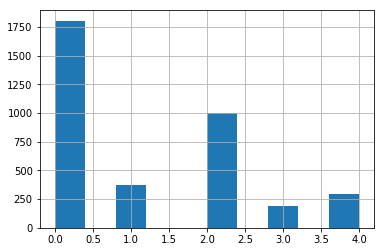

In [7]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

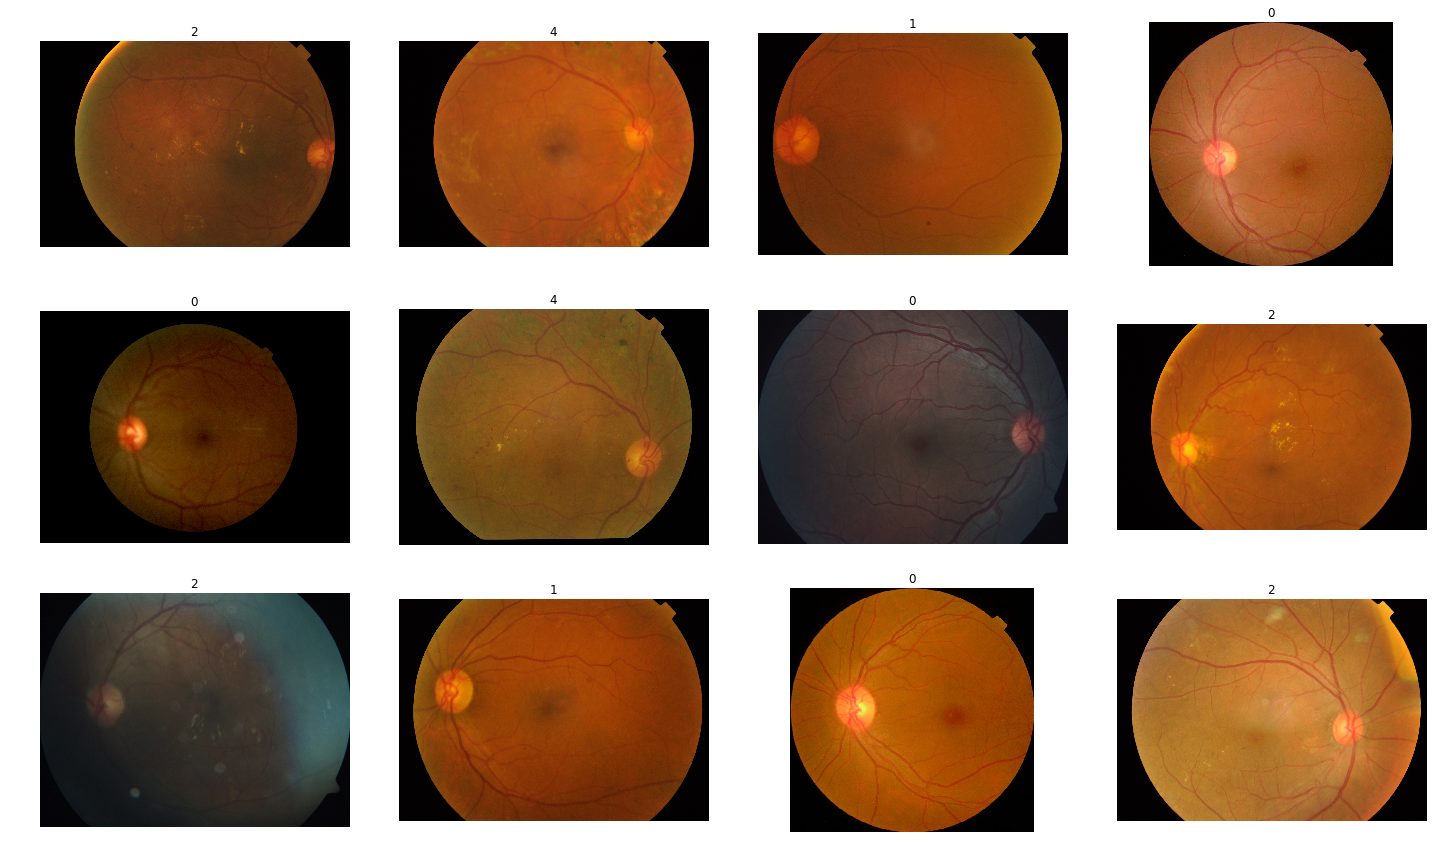

In [8]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# <a id='3'>Cropping images</a> 

We will resize the images to 256x256, then create a single numpy array to hold the data.

In [9]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#     image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image



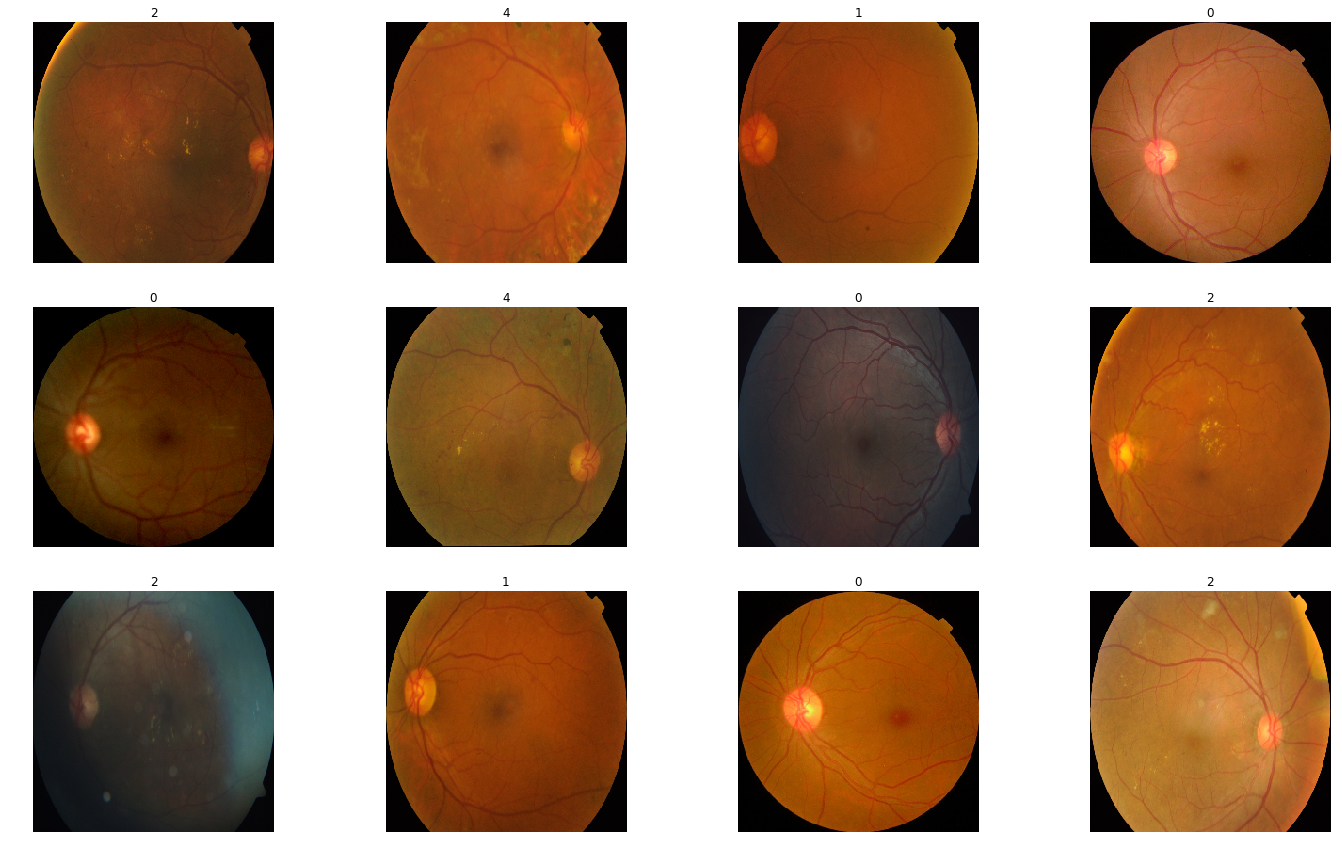

In [10]:
def display_samples_gaussian(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples_gaussian(train_df)

In [11]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [09:56<00:00,  5.38it/s]


In [12]:


y_train=train_df['diagnosis'].astype(int).values

print(y_train.shape)


(3662,)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

# <a id='4'>Mixup and Data Generator</a> 

In [13]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [14]:


train_gen = ImageDataGenerator(
        zoom_range=0.6,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# randomly flip images
        rotation_range = 360,
        rescale=1./255
    )

# <a id='5'>Quadratic Weighted Kappa</a> 

Quadratic Weighted Kappa (QWK, the greek letter $\kappa$), also known as Cohen's Kappa, is the official evaluation metric. For our kernel, we will use a custom callback to monitor the score, and plot it at the end.

### What is Cohen Kappa?

According to the [wikipedia article](https://en.wikipedia.org/wiki/Cohen%27s_kappa), we have
> The definition of $\kappa$ is:
> $$\kappa \equiv \frac{p_o - p_e}{1 - p_e}$$
> where $p_o$ is the relative observed agreement among raters (identical to accuracy), and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly seeing each category.

### How is it computed?

Let's take the example of a binary classification problem. Say we have:

In [15]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

We can construct the following table:

| true | pred | agreement      |
|------|------|----------------|
| 1    | 1    | true positive  |
| 0    | 0    | true negative  |
| 1    | 0    | false negative |
| 1    | 0    | false negative |
| 0    | 0    | true negative  |
| 1    | 1    | true positive  |


Then the "observed proportionate agreement" is calculated exactly the same way as accuracy:

$$
p_o = acc = \frac{tp + tn}{all} = {2 + 2}{6} = 0.66
$$

This can be confirmed using scikit-learn:

In [16]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

Additionally, we also need to compute `p_e`:

$$p_{yes} = \frac{tp + fp}{all} \frac{tp + fn}{all} = \frac{2}{6} \frac{4}{6} = 0.222$$

$$p_{no} = \frac{fn + tn}{all} \frac{fp + tn}{all} = \frac{4}{6} \frac{2}{6} = 0.222$$

$$p_{e} = p_{yes} + p_{no} = 0.222 + 0.222 = 0.444$$

Finally,

$$
\kappa = \frac{p_o - p_e}{1-p_e} = \frac{0.666 - 0.444}{1 - 0.444} = 0.4
$$

Let's verify with scikit-learn:

In [17]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

### What is the weighted kappa?

The wikipedia page offer a very concise explanation: 
> The weighted kappa allows disagreements to be weighted differently and is especially useful when **codes are ordered**. Three matrices are involved, the matrix of observed scores, the matrix of expected scores based on chance agreement, and the weight matrix. Weight matrix cells located on the diagonal (upper-left to bottom-right) represent agreement and thus contain zeros. Off-diagonal cells contain weights indicating the seriousness of that disagreement.

Simply put, if two scores disagree, then the penalty will depend on how far they are apart. That means that our score will be higher if (a) the real value is 4 but the model predicts a 3, and the score will be lower if (b) the model instead predicts a 0. This metric makes sense for this competition, since the labels 0-4 indicates how severe the illness is. Intuitively, a model that predicts a severe retinopathy (3) when it is in reality a proliferative retinopathy (4) is probably better than a model that predicts a mild retinopathy (1).

### Creating keras callback for QWK

In [18]:
def get_preds(y_hat):
    coef=[0.5,1.5,2.5,3.5]
    if coef[0]>=y_hat:
        y_hat=0
    elif coef[1]>=y_hat:
        y_hat=1
    elif coef[2]>=y_hat:
        y_hat=2
    elif coef[3]>=y_hat:
        y_hat=3
    else:
        y_hat=4
            
    return y_hat

In [19]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []
        self.fold = fold_
        
    def on_epoch_end(self, epoch, logs={}):

        X_val, y_val = self.validation_data[:2]

        
        y_pred = self.model.predict(X_val)

        for i in range(len(y_pred)):
            y_pred[i] = get_preds(y_pred[i])
        
        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            model.save_weights('model_new.h5')
            model_json = model.to_json()
            with open('model_new.json', "w") as json_file:
                json_file.write(model_json)
            json_file.close()
            

        

        return

# <a id='6'>Model : EfficientNetB3 </a> 

In [20]:
json_file=open('../input/effb3-train-on-old-new-as-val/model.json','r')
json_model=json_file.read()
json_file.close()

In [21]:
model=model_from_json(json_model)
model.load_weights('../input/effb3-train-on-old-new-as-val/model.h5')

In [22]:
model.compile( loss = 'mean_squared_error', metrics = ['accuracy'], optimizer = Adam(lr=0.0005) )

# <a id='7'>Training and Evaluation</a> 

In [23]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

print(test_df.shape)

(1928, 1)


In [24]:
from sklearn.model_selection import StratifiedKFold
import gc




kappa_metrics = Metrics()
test_df['diagnosis'] = 0
# est=EarlyStopping(monitor='val_loss',patience=5, min_delta=0.005)
call_backs=[kappa_metrics]
n_folds=5
skf=StratifiedKFold(n_splits=n_folds, random_state=2019)

for fold_, (trn_idx,val_idx) in enumerate(skf.split(x_train,y_train)):
    
    print('Fold {}'.format(fold_+1))
    
   
    x_train_, x_val = x_train[trn_idx], x_train[val_idx]
    y_train_, y_val = y_train[trn_idx], y_train[val_idx]
    
    x_val=x_val/255
    
    data_generator = train_gen.flow(x_train_, y_train_, batch_size=BATCH_SIZE, seed=2019)
    
    history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train_.shape[0] / BATCH_SIZE,
    validation_data=(x_val,y_val),
     epochs= 5,
    callbacks=call_backs)
    
    del x_train_, x_val, y_train_, y_val, data_generator
    
    gc.collect()
    
    if fold_ == 1:
        model.load_weights('model_new.h5')
        model.save_weights('model_first.h5')
        model_json = model.to_json()
        with open('model_first.json', "w") as json_file:
            json_file.write(model_json)
        json_file.close()
            
    if fold_ == 2:
        model.load_weights('model_new.h5')
        model.save_weights('model_second.h5')
        model_json = model.to_json()
        with open('model_second.json', "w") as json_file:
            json_file.write(model_json)
        json_file.close()
            
    if fold_ == 3:
        model.load_weights('model_new.h5')
        model.save_weights('model_third.h5')
        model_json = model.to_json()
        with open('model_third.json', "w") as json_file:
            json_file.write(model_json)
        json_file.close()
            
    if fold_ == 4:
        model.load_weights('model_new.h5')
        model.save_weights('model_fourth.h5')
        model_json = model.to_json()
        with open('model_fourth.json', "w") as json_file:
            json_file.write(model_json)
        json_file.close()
            
    if fold_ == 5:
        model.load_weights('model_new.h5')
        model.save_weights('model_fifth.h5')
        model_json = model.to_json()
        with open('model_fifth.json', "w") as json_file:
            json_file.write(model_json)
        json_file.close()

Fold 1
Epoch 1/5
184/183 [==============================] - 117s 635ms/step - loss: 0.3659 - acc: 0.7422 - val_loss: 0.4927 - val_acc: 0.7735
val_kappa: 0.9042
Validation Kappa has improved. Saving model.
Epoch 2/5
184/183 [==============================] - 83s 451ms/step - loss: 0.3264 - acc: 0.7555 - val_loss: 0.3726 - val_acc: 0.7790
val_kappa: 0.9036
Epoch 3/5
184/183 [==============================] - 83s 449ms/step - loss: 0.3110 - acc: 0.7599 - val_loss: 0.2991 - val_acc: 0.7735
val_kappa: 0.9062
Validation Kappa has improved. Saving model.
Epoch 4/5
184/183 [==============================] - 81s 441ms/step - loss: 0.2986 - acc: 0.7629 - val_loss: 0.2937 - val_acc: 0.7817
val_kappa: 0.9091
Validation Kappa has improved. Saving model.
Epoch 5/5
184/183 [==============================] - 82s 444ms/step - loss: 0.3071 - acc: 0.7616 - val_loss: 0.2720 - val_acc: 0.7694
val_kappa: 0.9080
Fold 2
Epoch 1/5
184/183 [==============================] - 83s 448ms/step - loss: 0.2576 - acc: 